# PCA構造解析（Adult / Census Income）

## 目的

本ノートブックでは、UCI Adult（Census Income）データセットの数値特徴量に対して主成分分析（PCA）を適用し、データの分散構造および潜在軸の解釈を行う。

各主成分について負荷量を確認し、どの変数が分散方向を支配しているかを把握する。また、主成分スコアの分布および目的変数（income）との関係を可視化し、特徴量空間の構造的理解を得る。

さらに、Hotelling’s T² および Q（SPE）を併用し、分散方向と残差方向の観点からデータの位置づけを補助的に評価する。

## 目次

1. データ読み込み・前処理・PCA学習
2. 寄与率・固有値
3. 主成分負荷量（Loadings）
4. 主成分スコア可視化
5. Hotelling’s T² / Q（SPE）分析
6. 構造解釈・考察

## 1. データ読み込み・前処理・PCA学習

In [1]:
import sys
from pathlib import Path

# --- プロジェクトルート自動検出 ---
ROOT = Path.cwd()
while not (ROOT / "data").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

# --- imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.pca import preprocess_pca,compute_loadings, compute_T2_Q, fit_pca, compute_scores

# --- paths ---
RAW_TRAIN = ROOT / "data/raw/adult.data"

# --- preprocess ---
X_scaled, y_train, feature_cols, scaler = preprocess_pca(RAW_TRAIN)

# --- PCA fit ---
pca = fit_pca(X_scaled)


## 2. 寄与率・固有値の確認

主成分分析における固有値は、各主成分が保持する分散量を表す指標であり、寄与率はその分散が全体分散に対して占める割合を示す。本節では、固有値および寄与率を確認することで、どの主成分がデータ構造の説明において重要であるかを評価する。

一般に、固有値の大きい主成分ほど多くの情報（分散）を保持しており、寄与率の累積値は低次元近似の妥当性を判断する基準となる。特に、累積寄与率が十分に高い値に達する主成分数は、次元削減や可視化対象の選定において実務的な意味を持つ。

ここでは、各主成分の固有値、寄与率、および累積寄与率を確認し、数値特徴量空間の分散構造が少数の主成分によってどの程度説明可能であるかを把握する。

In [2]:
# --- 固有値・寄与率 ---
eigvals = pca.explained_variance_
ratios  = pca.explained_variance_ratio_
cum_ratios = np.cumsum(ratios)

ev_df = pd.DataFrame({
    "主成分": [f"PC{i+1}" for i in range(len(eigvals))],
    "固有値": eigvals,
    "寄与率": ratios,
    "累積寄与率": cum_ratios
})

ev_df



,主成分,固有値,寄与率,累積寄与率
0,PC1,1.296751,0.259342,0.259342
1,PC2,1.030257,0.206045,0.465387
2,PC3,0.973965,0.194787,0.660174
3,PC4,0.887594,0.177513,0.837688
4,PC5,0.811587,0.162312,1.000000


主成分の寄与率を確認すると、PC1の寄与率は約25.9%、PC2までの累積寄与率は約46.5%となり、分散は特定の単一主成分に極端に集中していないことが分かる。固有値の減衰は比較的なだらかであり、数値特徴量の分散構造は単一要因ではなく複数要因によって構成されている。この結果から、Adultデータセットの数値特徴量空間は多因子分散構造を持つことが確認できる。

## 3. 主成分負荷量（Loadings）

主成分負荷量は、各主成分が元の特徴量のどの変数によって構成されているかを示す指標である。負荷量の大きさは、その主成分軸に対する各変数の寄与度および影響の強さを表す。

本節では、各主成分における負荷量を確認し、主成分軸の意味解釈を行うための基礎情報を得ることを目的とする。特に、負荷量の絶対値が大きい変数は、その主成分の分散方向を規定する主要因として解釈できる。

ここでは、主成分ごとの負荷量を列名付きで表示し、どの数値特徴量が各主成分に強く影響しているかを観察する。

In [3]:
# --- Loadings（主成分負荷量） ---
loadings_df = compute_loadings(pca, feature_cols)

k = 4
for i in range(k):
    s = loadings_df[f"PC{i+1}"].sort_values(key=np.abs, ascending=False)
    print(f"第{i+1}主成分負荷量\n{s}\n")


第1主成分負荷量
education-num     0.565057
hours-per-week    0.531774
capital-gain      0.439483
age               0.360978
capital-loss      0.272906
Name: PC1, dtype: float64

第2主成分負荷量
capital-loss      0.802157
capital-gain     -0.590667
age               0.079744
hours-per-week    0.034242
education-num    -0.011184
Name: PC2, dtype: float64

第3主成分負荷量
age               0.867600
education-num    -0.422693
hours-per-week   -0.235557
capital-gain      0.114494
capital-loss      0.002220
Name: PC3, dtype: float64

第4主成分負荷量
hours-per-week    0.743191
capital-gain     -0.463331
capital-loss     -0.390745
education-num    -0.243233
age               0.145420
Name: PC4, dtype: float64



主成分負荷量の特徴：
- PC1
    - education-num, hours-per-week, capital-gain, age の寄与が大きい
    - 人的資本・労働投入・収益性に関連する分散軸

- PC2
    - capital-loss の寄与が最大、capital-gain が逆方向に大きい
    - 資本損失と資本利得の対立を表す軸
- PC3
    - age の寄与が支配的
    - 年齢主導の分散方向
- PC4
    - hours-per-week の寄与が最大
    - 労働時間主導の分散軸

## 4. 主成分スコア可視化

PCAで得られた主成分スコアを用いて分布構造を確認する。
まず PC1・PC2スコアのヒストグラム を作成し、
各主成分方向の分布形状およびクラス差を観察する。

その後、PC1 × PC2 の散布図（incomeで色分け） を可視化し、
主成分空間におけるクラス分布の配置と重なりを確認する。

### 4.1 PC1・PC2スコアのヒストグラム

PC1およびPC2の主成分スコアについてヒストグラムを作成し、
各主成分方向の分布形状を確認する。

本可視化では、
- 分布の広がり
- 歪み・裾の形状
- 極端値の有無
- incomeクラス間の分布差

を観察する。

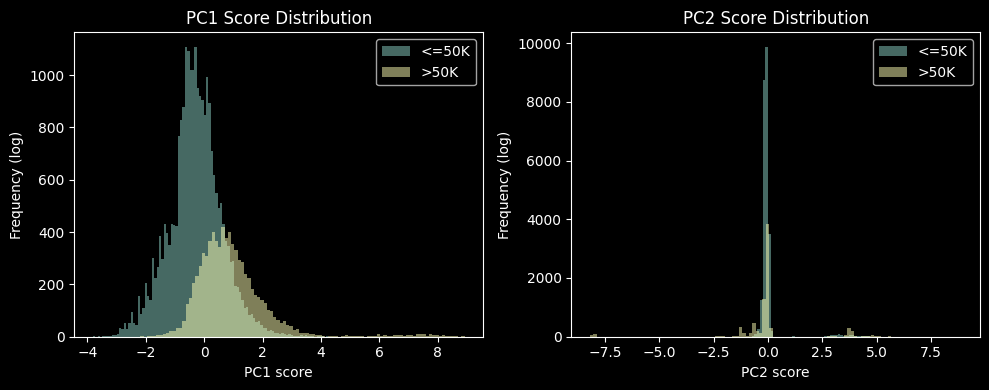

In [17]:
# --- scores ---
scores = compute_scores(pca, X_scaled, n_components=2)

# --- income → 0/1 ---
yy = (y_train.astype(str).str.strip() == ">50K").astype(int)

# --- figure（1画像2枚）---
plt.figure(figsize=(10, 4))

# ===== PC1 =====
plt.subplot(1, 2, 1)
plt.hist(scores[yy == 0, 0], bins=100, alpha=0.5, label="<=50K")
plt.hist(scores[yy == 1, 0], bins=100, alpha=0.5, label=">50K")
plt.xlabel("PC1 score")
plt.ylabel("Frequency (log)")
plt.title("PC1 Score Distribution")
plt.legend()

# ===== PC2 =====
plt.subplot(1, 2, 2)
plt.hist(scores[yy == 0, 1], bins=100, alpha=0.5, label="<=50K")
plt.hist(scores[yy == 1, 1], bins=100, alpha=0.5, label=">50K")
plt.xlabel("PC2 score")
plt.ylabel("Frequency (log)")
plt.title("PC2 Score Distribution")
plt.legend()

plt.tight_layout()
plt.show()

PC1スコア分布では income クラス間で平均位置のずれが確認された。
`>50K`クラスは高スコア側へ偏る傾向を示す。

一方で、広いスコア領域においてクラス分布の重なりが観察され、
特に PC1スコアが4以下では混在が顕著である。

このことから、PC1方向はクラス差を一定程度反映するものの、
PC1単独での分離能力は限定的である。

PC2スコア分布は0付近への集中が支配的であり、
クラス間の明確な分離傾向は確認されなかった。

また、PC2分布の裾に極端スコア領域が見られ、
少数の特殊サンプル群の存在が示唆される。

### 4.1 PC1 × PC2 の散布図（incomeで色分け）

PC1およびPC2の主成分スコアを用いた散布図を作成し、
目的変数 income（>50K / <=50K）によって色分けする。

本可視化の目的は、主成分空間におけるクラス分布の配置、
重なり、偏在傾向を視覚的に確認することである。

特に以下の点を観察する：

- クラス分布の重なり具合

- 分離傾向の有無

- 軸方向の偏り

- 極端スコア領域への集中

この段階では分類性能の評価ではなく、
分布構造の解釈補助 を主眼とする

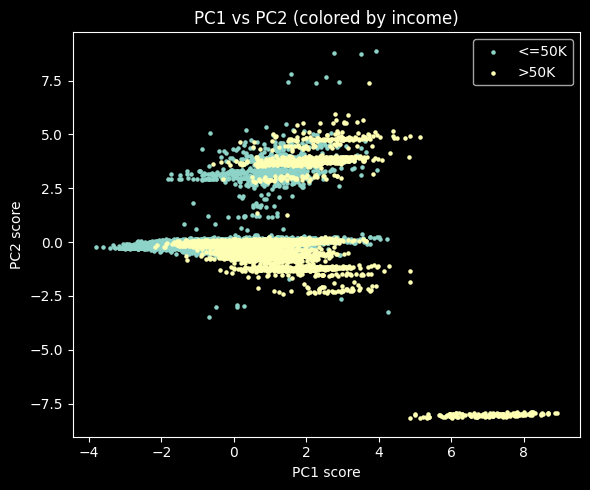

In [19]:
# --- scores (PC1, PC2) ---
scores = compute_scores(pca, X_scaled, n_components=2)
pc1 = scores[:, 0]
pc2 = scores[:, 1]

# --- income整形（末尾ドット対策）---
y_plot = (
    y_train.astype(str)
           .str.strip()
           .str.rstrip(".")
)

# --- 散布図 ---
plt.figure(figsize=(6, 5))

for label in y_plot.unique():
    mask = y_plot == label
    plt.scatter(pc1[mask], pc2[mask], s=5, label=label)

plt.xlabel("PC1 score")
plt.ylabel("PC2 score")
plt.title("PC1 vs PC2 (colored by income)")
plt.legend()
plt.tight_layout()
plt.show()

PC1 × PC2 散布図では、主成分空間におけるincomeクラスの配置を確認した。

PC1方向に沿ってクラス分布の偏りが観察され、
`>50K`クラスは高スコア側へ分布する傾向を示した。

一方で、PC1低〜中スコア領域ではクラスの重なりが大きく、
明確な線形分離構造は確認されなかった。

PC2方向ではクラス分布の分離傾向は限定的であり、
主分離軸としての寄与は小さい。

また、PC2低スコア領域に帯状の集中が確認され、
特定サンプル群の存在が示唆される。

## 5. T² / Q 分析

主成分空間におけるサンプルの位置特性を評価するため、
Hotelling’s T² および Q（SPE: Squared Prediction Error）を算出する。

T²は主成分空間内での距離を表し、
モデル化された分散構造に対する偏差の大きさを評価する指標である。

Qは再構成残差に基づく指標であり、
主成分で説明されない成分の大きさを評価する。

これらの指標により、

- 分散構造からの逸脱

- モデル外挙動

- 潜在的外れサンプル

を確認する。

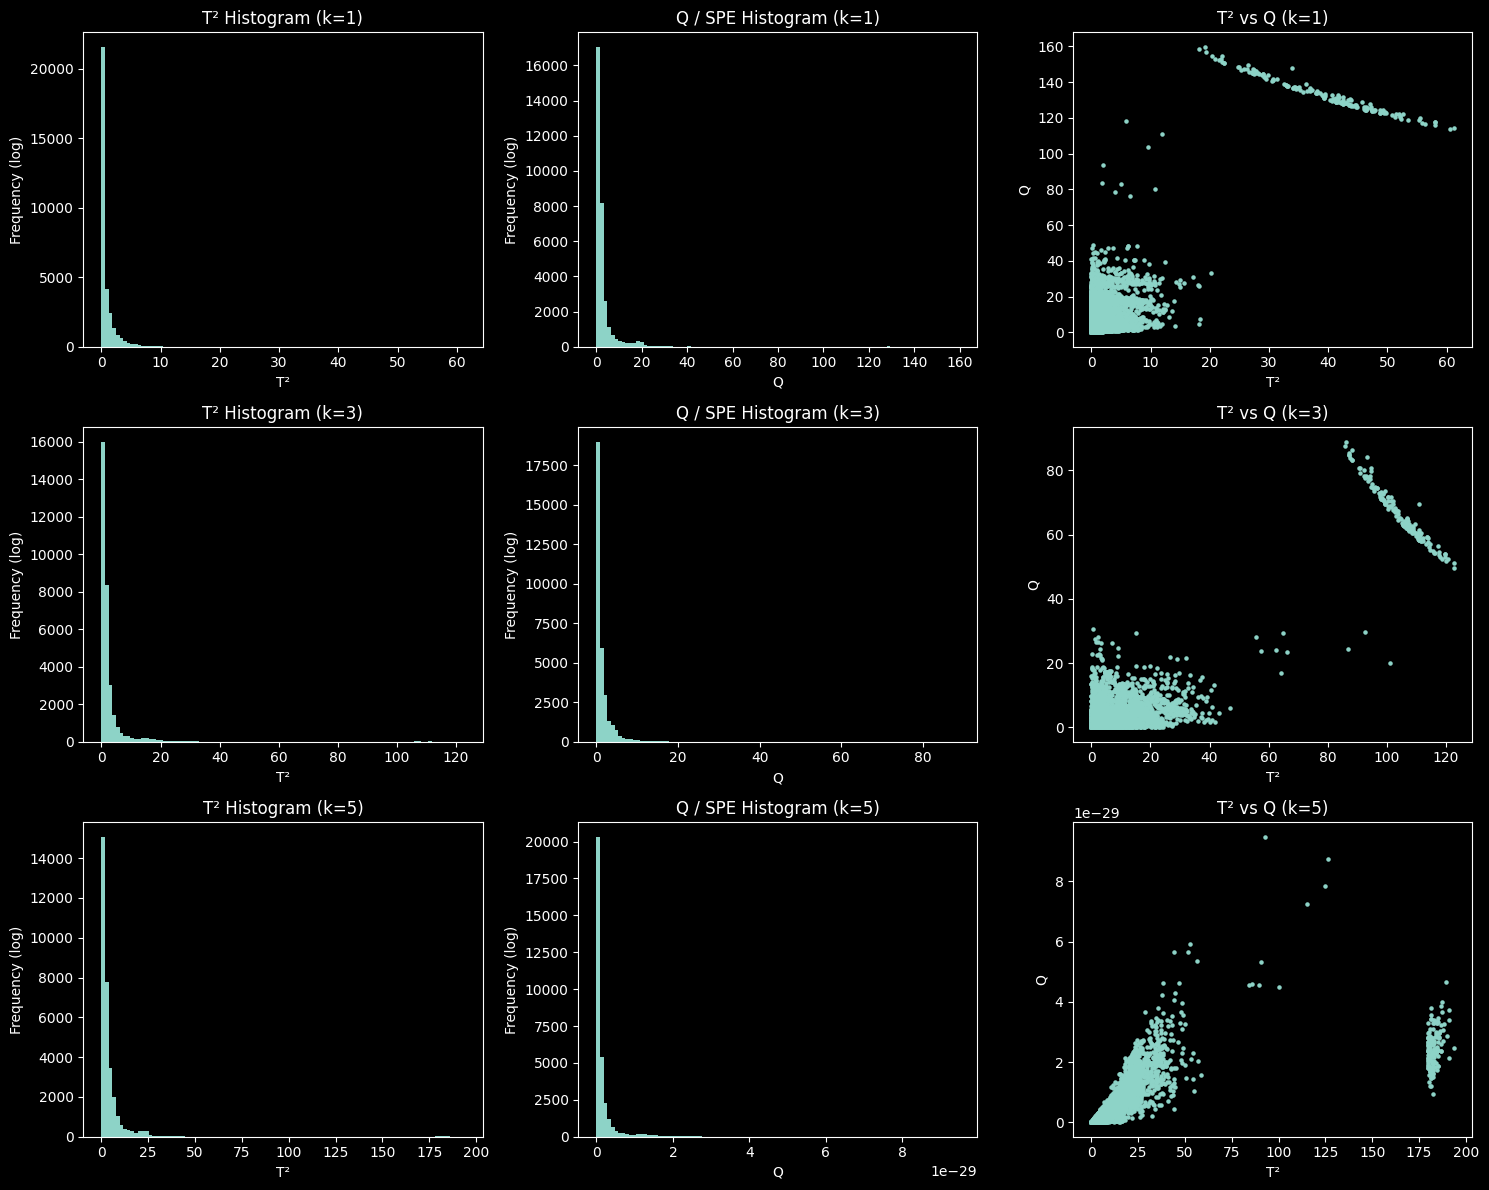

In [20]:
import matplotlib.pyplot as plt


# --- 前提 ---
# X_scaled: (n_samples, n_features) = StandardScaler後の行列
# pca: PCA() を fit 済み
# X_pca: pca.transform(X_scaled) の結果

ks = [1, 3, 5]

plt.figure(figsize=(15, 12))

for i, k in enumerate(ks, start=1):
    T2, Q = compute_T2_Q(X_scaled, pca, n_components=k)

    # --- T² histogram ---
    plt.subplot(len(ks), 3, (i - 1) * 3 + 1)
    plt.hist(T2, bins=100)
    plt.title(f"T² Histogram (k={k})")
    plt.xlabel("T²")
    plt.ylabel("Frequency (log)")

    # --- Q histogram ---
    plt.subplot(len(ks), 3, (i - 1) * 3 + 2)
    plt.hist(Q, bins=100)
    plt.title(f"Q / SPE Histogram (k={k})")
    plt.xlabel("Q")
    plt.ylabel("Frequency (log)")

    # --- Scatter ---
    plt.subplot(len(ks), 3, (i - 1) * 3 + 3)
    plt.scatter(T2, Q, s=5)
    plt.title(f"T² vs Q (k={k})")
    plt.xlabel("T²")
    plt.ylabel("Q")

plt.tight_layout()
plt.show()



T²、Q、およびT²–Q関係について確認した。

T²分布は低値領域への集中が支配的であり、
高T²領域は少数サンプルに限られる。これは主成分空間において
大部分の観測が中心領域に位置していることを示す。

Q分布は主成分数kの増加に伴い縮小し、
k=5（フル成分）では理論的にQ≈0となった。これは再構成誤差が
ほぼ消失することと整合する。

T²–Q関係では、k=1およびk=3において
T²の増加に伴いQが減少する負の関係傾向が観察された。
一方、k=5ではQ≈0となるため、両指標間の関係構造は成立しない。

## 6. 構造解釈・考察

PCAおよびT² / Q分析の結果から、入力変数空間の構造特性を確認した。

主成分寄与率は特定成分への極端な集中を示さず、
分散は複数因子へ分配される構造を持つことが確認された。

PC1方向には income クラス間の偏りが観察され、
人的資本・労働投入・収益関連変数が統合的に寄与する軸として機能している。

一方、PC2は分布集中と裾の広がりを併せ持ち、
通常サンプル群と少数特殊群の混在構造を反映した軸と解釈される。

T²分布は低値領域への集中が支配的であり、
大部分の観測は主成分空間の中心領域に位置する。

Qは主成分数の増加に伴い縮小し、
フル成分条件では理論的関係と整合的Q≈0となった。

T²–Q関係では、低次元モデルにおいて
説明分散と残差分散のトレードオフ的傾向が確認された。

以上より、本データは多因子的分散構造および
少数極端サンプルを含む分布特性を持つことが示唆される。